In [1]:
from huggingface_hub import notebook_login
import gc
from glob import glob
import torch
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

# Prepare data

In [3]:
from huggingface_hub import hf_hub_download

# dataset = hf_hub_download(repo_id="ai-lab/MBD", filename="ptls.tar.gz", repo_type="dataset", local_dir='../data/mbd')
# dataset = hf_hub_download(repo_id="ai-lab/MBD", filename="targets.tar.gz", repo_type="dataset", local_dir='../data/mbd')
# !tar -xvzf ./data/mbd/ptls.tar.gz ./data/mbd
# !tar -xvzf ./data/mbd/targets.tar.gz ./data/mbd

# Geo to text

In [4]:
from datetime import datetime

MAX_LEN = 256
GEO_COLUMNS = ["client_id", 'event_time', 'geohash_4', 'geohash_5', 'geohash_6']


def geo_to_text(geo, columns=GEO_COLUMNS, max_len=MAX_LEN):
    
    client_id = geo['client_id']
    del geo['client_id']
    
    for k in columns:
        if k == "event_time":
            geo[k] = list(map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'), geo[k]))
                
    df = pd.DataFrame(geo)
    df = df.loc[(df.shift() != df).any(axis=1)].tail(MAX_LEN)
    
    return client_id, df.to_string(index=False)

In [20]:

def get_geo_data(geo_path):
    data_geo = pd.read_parquet(geo_path, columns=GEO_COLUMNS)
    df_geo = pd.DataFrame(map(geo_to_text, tqdm(data_geo.to_dict("records"))), columns=["client_id", "geo"])
    return df_geo.to_dict('records')

# Write to json

In [21]:
import json

client_ids = []

for fold in range(5):
    
    data = get_geo_data(f'../data/mbd/geo/fold={fold}/')
    
    with open(f'../data/mbd/geo/json/mbd_fold_{fold}.jsonl', 'w') as outfile:
        for d in tqdm(data):
            client_id, text = d['client_id'], d['geo']
            entry = {'client_id': client_id, 'text': text}
            json.dump(entry, outfile)
            outfile.write('\n')
            client_ids.append(client_id)
            
len(set(client_ids))

100%|██████████| 145330/145330 [00:06<00:00, 23143.71it/s]


726678

# Check number of tokens

In [23]:
!ls ../data/mbd/geo/json/

mbd_fold_0.jsonl  mbd_fold_2.jsonl  mbd_fold_4.jsonl
mbd_fold_1.jsonl  mbd_fold_3.jsonl


In [32]:
from transformers import LlamaTokenizer
name = '/home_from_vm2/morlov/ggcht/small_models_run/gigar2-2b-450k-hf/'
tokenizer = LlamaTokenizer.from_pretrained(name)

In [34]:
lens = []

data = pd.read_json('../data/json_balanced_geo.jsonl', lines = True).head(1000).reset_index(drop=True)

for d in tqdm(data.to_dict('records')):
    client_id, text = d['client_id'], d['text']
    tokenized = tokenizer(text, padding="max_length", truncation=True)
    lens.append([client_id, len(tokenized['input_ids'])])

100%|██████████| 1000/1000 [00:09<00:00, 100.30it/s]


In [35]:
df_lens = pd.DataFrame(lens, columns=['client_ids', 'tokens'])

In [36]:
df_lens.head()

,client_ids,tokens
0,102779fbfb73ecb44af2d73a1f2a936adfc01837162e7e...,5977
1,16402b565b79328b4e8071cac44e60e6d05044ace0fc4c...,5799
2,20098b632cdf1307820b9a155740a854b5609b62bc2478...,694
3,22c52cfd1e3079f6e47333a00d4a79cec53081389bc26a...,5596
4,23991a67bdefd64017fd2b2cdfdbf057972dc42c8c2455...,1508


<Axes: >

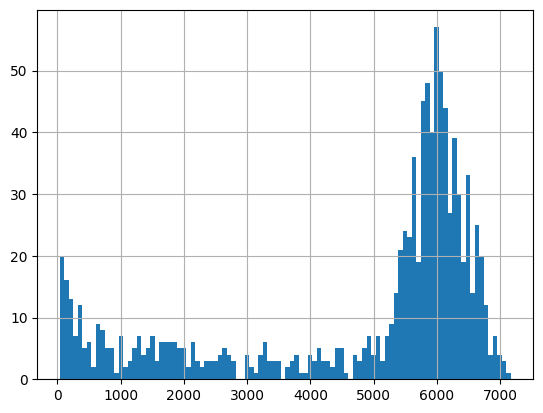

In [37]:
df_lens['tokens'].hist(bins=100)

In [38]:
df_lens['tokens'].describe()

count    1000.00000
mean     4751.74200
std      2107.93585
min        41.00000
25%      3607.50000
50%      5782.00000
75%      6138.75000
max      7168.00000
Name: tokens, dtype: float64

In [43]:
print(data['text'][0])

event_time  geohash_4  geohash_5  geohash_6
2022-07-14         43        106       1905
2022-07-17         43        106       8502
2022-07-17         43        106       2692
2022-07-18         43        106       4838
2022-07-18         43        180       1969
2022-07-18         43        106       2616
2022-07-19         43        106       2616
2022-07-19         43        106       5773
2022-07-19         43        106       2616
2022-07-19         43        106       2692
2022-07-20         43        180       1481
2022-07-20         43        106       2616
2022-07-20         43        180       4067
2022-07-21         43        106       8502
2022-07-21         43        180       2015
2022-07-22         43        106       2616
2022-07-22         43      10001      10001
2022-07-22         43        106       2616
2022-07-23         43        106       8502
2022-07-23         43        106       2616
2022-07-24         43        106       4838
2022-07-26         43        106

# Balanced dataset

In [24]:
import pandas as pd
balanced_ids = pd.read_parquet('../data/mbd_targets_balanced.parquet', columns=['client_id'])

In [25]:
balanced_ids.shape

(70532, 1)

In [26]:
ids = set(balanced_ids['client_id'])

In [27]:
json_files = glob('../data/mbd/geo/json/mbd_fold_*.jsonl', recursive=True)
json_files  

['../data/mbd/geo/json/mbd_fold_4.jsonl',
 '../data/mbd/geo/json/mbd_fold_1.jsonl',
 '../data/mbd/geo/json/mbd_fold_2.jsonl',
 '../data/mbd/geo/json/mbd_fold_3.jsonl',
 '../data/mbd/geo/json/mbd_fold_0.jsonl']

In [28]:
import json
from tqdm import tqdm

json_data = []

for json_file in json_files:
    with open(json_file) as f:
        for line in tqdm(f):
            x = json.loads(line)
            if x['client_id'] in ids:
                json_data.append(x)
        
print(len(json_data))

145330it [00:03, 42408.80it/s]
145411it [00:03, 41849.64it/s]
145072it [00:03, 41898.97it/s]
145530it [00:03, 41612.95it/s]
145335it [00:03, 41289.93it/s]

51761


In [29]:
with open(f'../data/mbd/json_balanced_geo.jsonl', 'w') as outfile:
    for entry in tqdm(json_data):
        json.dump(entry, outfile)
        outfile.write('\n')

100%|██████████| 51761/51761 [00:02<00:00, 25290.74it/s]
